<a href="https://colab.research.google.com/github/MahdiShahrabi/COVID19-Simulation/blob/Simulation-on-Subgraphs/Time%20Dimension/Time_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Loading Libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from random import uniform
from copy import deepcopy
import warnings
import pickle
from google.colab import drive
from time import gmtime, strftime
import pytz
import datetime as dt

In [0]:
## Function to geneate seed
def generateRandSeed(num,Graph):
    """ A simple function to generate random seed """
    out = np.random.choice(list(range(Graph.number_of_nodes())),num,replace=False)    
    return(out)

In [0]:
def Simulate_SIR_Time (Graph,Maximum_Time=100,Seasons=[50,100,150,200],P_seasons = [1,1,1,1],
                  Seeds = [0,7], n_dr=1, q_die=0.2, n_s=1, q_s=0.1, how='Transmission'):
    
  """ A function to run a cascade simulation on a graph.

  The cascade is based on the SIR model in each time step.
  ....

  Parameters
  ----------
  Graph: networkx.Graph object
    The graph to run the simulation on! Each edge must have a weight
    that shows the probability of transmission.

  Maximum_Time: int
    Maximum time that the simulation is run if it does not cnoverge!

  Seasons: list of integers
    Each element shows the moment of season change.

  P_seasons: list of floats
    The Pr[tansmission] is multiplied by the p_season for each season.

  Seeds: list of integers
    Initial Seeds.
  
  n_dr: int
    Number of time steps that after infection a node dies or recovers.
  
  q_die: float
    Probability of dying at n_dr day after infection

  n_s: int
    Number of time steps that after infection a node shows symptoms.
    After showing symptoms, edge weights are multiplied by q_s.

  q_s: float
    See n_s.

  how: str
    It can be 'Transmission' or 'New_Infection'. 
    In the 'Transmission' mode, R0 is calculated as the number of virus tranmission
     (ignoring the fact that the receiver node is already infected or not).
    In the 'New_Infection' mode, R0 is calculated the number of new infected nodes,
     caused by a node in its sickness period.
  
  Attention
  ---------
  If in this simulation if we put n_dr=1, we have the simple SIR model.

  """
  # Size of Graph
  lng = Graph.number_of_nodes()

  # Checking inputs
  if n_s>n_dr:
     warnings.warn("n_s(time to show symptoms) should be less than n_dr(time to die or recovers)")

  if len(Seeds)>lng:
      raise ValueError('"numSeed" cannot be larger than Graph size')
      
  if len([x for x in Seeds if x>=lng])>lng:
    raise ValueError('Initial Seeds must be in Graph!') 
        
  if not isinstance(Graph,nx.Graph):
     raise ValueError('"Graph" must be a networkx.Graph object!')
        
  if q_die>1 or q_die<0 or q_s<0 or q_s>1 or len([x for x in P_seasons if x<0]):
    raise ValueError('Probabilities (q_s,q_die, P_seasons) must be between 0 and 1!')
        
  if how not in ['Transmission','New_Infection']:
    raise ValueError('"how" must be "Transmission" or "New_Infection"')

  # Sorting elements of Seasons
  Seasons.sort()    
  
  # Declaring output list
  OUT=list()     

  ## Creating Neighbor List
  Neighbors_List = []
  Nodes = list(Graph.nodes())
  Nodes.sort(reverse=False)
  # Finding Neighbors of each node
  for node in list(Nodes):
      Neighbors_List.append(dict(Graph.adj[node]))


  ## Initializing the Status Lists
  Normal = list(range(lng))
  Infected = list()
  Died = list()
  Recovered = list()
  
  # Adding initial seeds to infected list
  Infected = [x for x in Seeds]

  # Timer for infecteds
  Infected_timer = [0]*len(Seeds)

  # Removing infecteds from Normal list
  for node in Infected:
      Normal.remove(node)
      
  # Declaring output R0 lists
  R0_Node_list = [0]*lng
  R0_time_list = []

  # Declaring level lists
  Normal_size =[]
  Infected_size =[]
  Recovered_size =[]
  Died_size =[]
  
  # Setting first elements
  Normal_size.append(len(Normal))
  Infected_size.append(len(Seeds))
  Recovered_size.append(0)
  Died_size.append(0)
  

  # Going through time 
  for t in range(1,Maximum_Time+1):
      
      # If there is no Infected we are on steady state. So quit!
      if len(Infected)==0:
          break
      # R_t
      R0_t = 0
    
      # Finding Season
      if  t<Seasons[0]:
          p_s = P_seasons[0]
      elif t>=Seasons[0] and t<Seasons[1]:
          p_s = P_seasons[1]
      elif t>=Seasons[1] and t<Seasons[2]:
          p_s = P_seasons[2]
      elif t>=Seasons[2] and t<Seasons[3]:
          p_s = P_seasons[3]
      else:
          p_s = 1

      # Finding nodes that must die or recover (based on the timer)
      DieRecover = [x for x,y in zip(Infected,Infected_timer) if y == n_dr]
      
      # For updating netwok, Finding nodes that their neighbor just died or . . .
      # . . . recovered so their neighbor list must be updated.                    
      nhbr_rd = set()

      # For each node in DieRecover list
      for node in DieRecover:
          # The neighbors of the dead or recoverd node need to be modified
          nhbr_rd = nhbr_rd.union(Graph.adj[node])    

          # We delete that node from infecteds and timer
          index = Infected.index(node)
          del Infected_timer[index]
          del Infected[index]

          # We remove the edges for that node (Recovereds can not get sick again)
          Graph.remove_edges_from(list(Graph.edges(node)))
          
          # We see they die or recover with respect to q_die
          if uniform(0,1) < q_die:
              # It dies
              Died.append(node)

          else:
              # It recovers
              Recovered.append(node)
      

      # Updating Neighbor List for nodes that their neighbrs are died or recoverd
      for neighbor in nhbr_rd:
          Neighbors_List[neighbor] = dict(Graph.adj[neighbor]) 

      # Cascade...
      # New infected nodes in each time step
      New_Infected = []
      # For each Infected node we try to find the transmissions
      for i in range(len(Infected)):

          # Infected node
          node = Infected[i]
          # Number of Transmission by this node in this time step
          R0 = 0
          
          # Checking if the node has symptoms
          if Infected_timer[i] < n_s:
              Q = 1
          else:
              Q = q_s
                   
          ## Finding the Neighbors of the node based on the how (transmission or new infection)
          if how=='Transmission':
              Neighbors = Neighbors_List[node]
          else:
              Neighbors = {k:v for k,v in Neighbors_List[node].items() if k in Normal}               
          
          # For each neighbor
          for advicee in Neighbors:
              
              # Gets informed with respect to edge probability, symptoms, season
              if  uniform(0,1)<Neighbors[advicee]['weight']*Q*p_s:
                  # Increasing the R-0 for node and time
                  R0+=1
                  R0_t+=1  

                  # If its a new node (which is not already informed) we update the list of informeds
                  if advicee in Normal:
                      Normal.remove(advicee)
                      New_Infected.append(advicee)
          

          # Updating number of new infected for this node
          R0_Node_list[node] = R0_Node_list[node]+R0
          

      ## Increasing Timer of nodes ##
      Infected_timer = [x+1 for x in Infected_timer]

      ## Updaint list of R_t
      try: 
        R0_time_list.append(R0_t/len(Infected))

      except:
        R0_time_list.append(np.nan)

      # Updating Infected list and the timer
      Infected = Infected + New_Infected
      Infected_timer = Infected_timer + len(New_Infected)*[0]
      
      # Updating level sizes in each step
      Normal_size.append(len(Normal))
      Infected_size.append(len(Infected))
      Recovered_size.append(len(Recovered))
      Died_size.append(len(Died))
          
  # Keeping nodes which got infected 
  R0_Infected_Nodes = {k:R0_Node_list[k] for k in range(len(R0_Node_list)) if k not in Normal}
  
  # The level outpu
  level = pd.DataFrame(data={'time':list(range(len(Normal_size))),
                             'Normal':Normal_size,
                             'Infected':Infected_size,
                             'Recovered':Recovered_size,
                             'Died':Died_size})
  
  ## Outputs
  # The size of cascade through time
  OUT.append(level)
  # Dictonary showing R0 for each node (not nodes normal nodes) 
  OUT.append(R0_Infected_Nodes)
  # R0 - average R0 for all nodes
  OUT.append(np.mean(list(R0_Infected_Nodes.values())))
  # The size of cascade (percentage)
  OUT.append((len(Died)+len(Recovered)+len(Infected))/lng)
  # R_T
  OUT.append(R0_time_list)


  return(OUT)

In [0]:
def plot_simulation_output(Graphsize,data,module=['Infected','Rt','Died']):

  lng = Graphsize

  time = list(range(0,len(data)))
  
  DATA ={'Normal':[x/lng for x in list(data.Normal)],'Infected':[x/lng for x in list(data.Infected)],'Died':[x/lng for x in list(data.Died)],'Rt':data.Rt}
  colors ={'Normal':'green','Infected':'blue','Died':'red','Rt':'black'}
  Ls ={'Normal':'solid','Infected':'solid','Died':'dashed','Rt':'dashed'}

  fig, ax1 = plt.subplots(1,1,figsize=(6,3), dpi= 120)
  for plot in module:
    if plot !='Rt':
      ax1.plot(time, DATA[plot] ,color=colors[plot],lw=1,label=plot,ls=Ls[plot])
    else:
      ax2 = ax1.twinx()
      ax2.plot(time, DATA[plot],color=colors[plot],lw=1,label=plot,ls=Ls[plot])
      ax2.set_ylabel('Rt', fontsize=5)
      ax2.tick_params(axis='y', rotation=0,labelsize=5 )
      
    

  if 'Rt' in module:
      ax2.grid(alpha=.4)
  else:
    ax1.grid(alpha=.4,axis='y')

  ax1.tick_params(axis='x', labelsize=5)
  ax1.set_ylabel('Percentage', fontsize=5)
  ax1.tick_params(axis='y', rotation=0,labelsize=5 )
  ax1.set_xticks(time[::1])
  ax1.set_xticklabels(time[::1])
  ax1.grid(alpha=.4,axis='x')

  fig.tight_layout()

  plt.title('Dynamic of Cascade in an Indian Village',fontsize=10)

  handles,labels = [],[]
  for ax in fig.axes:
      for h,l in zip(*ax.get_legend_handles_labels()):
          handles.append(h)
          labels.append(l)

  plt.legend(handles,labels,fontsize=7,loc='upper left')
  plt.show()
  return()

# **Run Your Simulation**

In the below example, we create an Erdos-Renyi graph and we run the simulation and plot the outputs.

The average R0 is 5.459, and the fraction of Infected people are 0.997, The method was "Transmission"


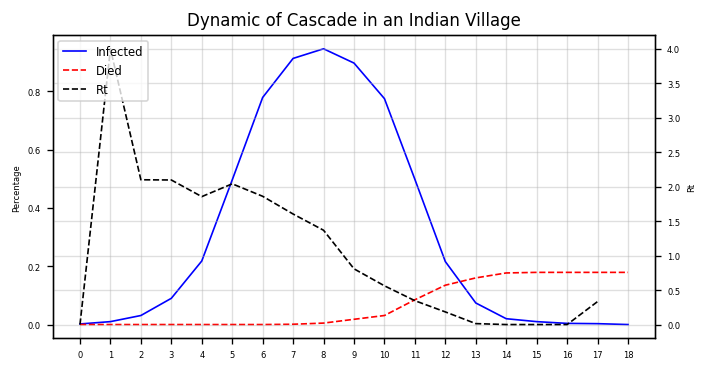

CPU times: user 1.71 s, sys: 121 ms, total: 1.83 s
Wall time: 1.71 s


In [51]:
%%time
# Example
n = 1000
d = 40
G = nx.erdos_renyi_graph(n,d/n)
edge_weight = dict(zip(G.edges(),[uniform(0.01,0.1) for x in range(len(G.edges()))]))
nx.set_edge_attributes(G,edge_weight,'weight')

method = 'Transmission'
out = Simulate_SIR_Time (deepcopy(G),Maximum_Time=10000,Seasons=[20,40,60,80],P_seasons = [1,1,1,1],
                   Seeds = generateRandSeed(2,G), n_dr=5, q_die=0.2, n_s=2, q_s=0.3, how=method)

print('The average R0 is {:0.3f}, and the fraction of Infected people are {:0.3f}, The method was "{}"'.format(out[2],out[3],method))
data = out[0]
data['Rt'] = 0
data['Rt'].iloc[1:] = out[4]
plot_simulation_output(Graphsize=G.number_of_nodes(),data = data,module=['Infected','Died','Rt'])

# **Simulation on Subgraphs**

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


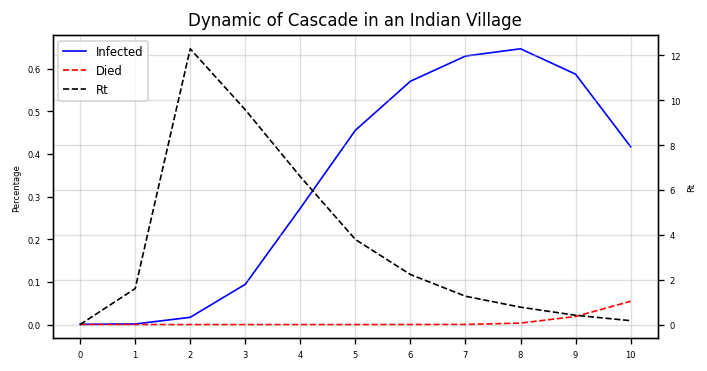

()

In [25]:
%%time
# Loading Gowalla network from google drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/Colab Notebooks/ColabData"
infile = open(DATA_PATH+'/gowalla_Graph','rb')
gowalla = pickle.load(infile)

# Creating a Graph based on the main network
G = gowalla

D = list(dict(G.degree()).values())

subgraph_repeat = 20
seed_repeat = 10
repeat = 5

hist, bins = np.histogram(D, bins=10000)

bin_midpoints = bins[:-1] + np.diff(bins)/2
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]

R0 = []
Rt = []
level_Infected = []
level_Normal = []
level_Died = []
cnt = 1
for i in range(subgraph_repeat):
  print(i+1,': {} from {}'.format(cnt,repeat*seed_repeat*subgraph_repeat),', and time is:',dt.datetime.now(pytz.timezone('Iran')).strftime('%T'))
  values = np.random.rand(10000)
  value_bins = np.searchsorted(cdf, values)
  random_from_cdf = bin_midpoints[value_bins]

  Graph = nx.expected_degree_graph(random_from_cdf)
  edge_weight = dict(zip(Graph.edges(),[uniform(0.01,0.3) for x in range(len(Graph.edges()))]))
  nx.set_edge_attributes(Graph,edge_weight,'weight')


  for j in range(seed_repeat):
    S = generateRandSeed(5,Graph)

    for k in range(repeat):
      out = Simulate_SIR_Time (deepcopy(Graph),Maximum_Time=10,Seasons=[20,40,60,80],P_seasons = [1,1,1,1],
                      Seeds = S, n_dr=5, q_die=0.2, n_s=2, q_s=0.3, how="Transmission")
      level_Infected.append(list(out[0].Infected))
      level_Normal.append(list(out[0].Normal))
      level_Died.append(list(out[0].Died))
      R0.append(out[2])
      Rt.append(out[4])
      cnt+=1


# Taking average
max_len = max([len(x) for x in level_Infected])

temp = np.array([x+(max_len-1-len(x))*[np.nan] for x in Rt])
Rt_ = np.nanmean(temp,axis=0)

temp = np.array([x+(max_len-len(x))*[x[len(x)-1]] for x in level_Infected])
level_Infected_ = np.nanmean(temp,axis=0)

temp = np.array([x+(max_len-len(list(x)))*[x[len(x)-1]] for x in level_Normal])
level_Normal_ = np.nanmean(temp,axis=0)

temp = np.array([x+(max_len-len(list(x)))*[x[len(x)-1]] for x in level_Died])
level_Died_ = np.nanmean(temp,axis=0)

data = pd.DataFrame(data={'time':list(range(max_len)),'Normal':list(level_Normal_),'Infected':list(level_Infected_),'Died':list(level_Died_)})
data['Rt'] = 0
data['Rt'].iloc[1:] = Rt_
data.to_csv('/content/drive/My Drive/Colab Notebooks/ColabData/subgraph_data.csv',index=0)

# Plotting Results
plot_simulation_output(data=data, Graphsize=10000)

# **Simulation on Main graph**

0 0 : 1 from 32 , time is: 2020-05-02 08:57:44
0 1 : 2 from 32 , time is: 2020-05-02 09:13:08
0 2 : 3 from 32 , time is: 2020-05-02 09:16:51
0 3 : 4 from 32 , time is: 2020-05-02 09:20:29
1 0 : 5 from 32 , time is: 2020-05-02 09:35:19
1 1 : 6 from 32 , time is: 2020-05-02 09:51:14
1 2 : 7 from 32 , time is: 2020-05-02 09:54:55
1 3 : 8 from 32 , time is: 2020-05-02 09:58:33
2 0 : 9 from 32 , time is: 2020-05-02 10:14:41
2 1 : 10 from 32 , time is: 2020-05-02 10:33:03
2 2 : 11 from 32 , time is: 2020-05-02 10:52:10
2 3 : 12 from 32 , time is: 2020-05-02 11:11:21
3 0 : 13 from 32 , time is: 2020-05-02 11:30:44
3 1 : 14 from 32 , time is: 2020-05-02 11:34:19
3 2 : 15 from 32 , time is: 2020-05-02 11:37:43
3 3 : 16 from 32 , time is: 2020-05-02 11:41:03
4 0 : 17 from 32 , time is: 2020-05-02 11:44:24
4 1 : 18 from 32 , time is: 2020-05-02 11:56:09
4 2 : 19 from 32 , time is: 2020-05-02 11:59:37
4 3 : 20 from 32 , time is: 2020-05-02 12:10:22
5 0 : 21 from 32 , time is: 2020-05-02 12:13:54
5

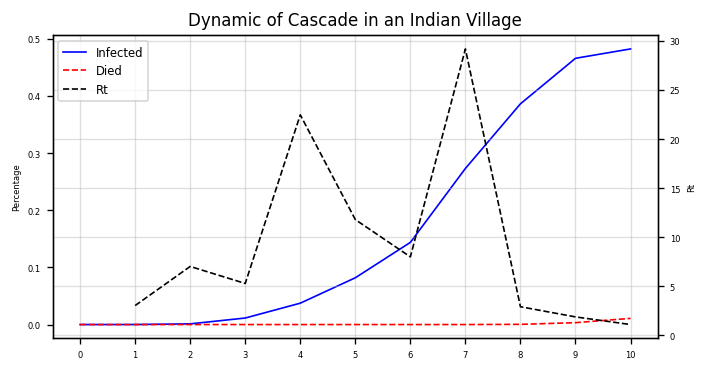

CPU times: user 6h 9min 38s, sys: 14.6 s, total: 6h 9min 53s
Wall time: 6h 10min 4s


In [0]:
%%time
# Creating a Graph based on the main network

G = gowalla
edge_weight = dict(zip(G.edges(),[uniform(0.01,0.3) for x in range(len(G.edges()))]))
nx.set_edge_attributes(G,edge_weight,'weight')


seed_repeat = 8
repeat = 4

R0 = []
Rt = []
level_Infected = []
level_Normal = []
level_Died = []
cnt = 1


for j in range(seed_repeat):
  S = generateRandSeed(2,G)

  for k in range(repeat):
    print(j+1,k+1,': {} from {}'.format(cnt,repeat*seed_repeat),', time is:',dt.datetime.now(pytz.timezone('Iran')).strftime('%T')))
    out = Simulate_SIR_Time (deepcopy(G),Maximum_Time=10,Seasons=[20,40,60,80],P_seasons = [1,1,1,1],
                    Seeds = S, n_dr=5, q_die=0.2, n_s=2, q_s=0.3, how="Transmission")
    level_Infected.append(list(out[0].Infected))
    level_Normal.append(list(out[0].Normal))
    level_Died.append(list(out[0].Died))
    R0.append(out[2])
    Rt.append(out[4])
    cnt+=1


### Simulation on Subgraphs
max_len = max([len(x) for x in level_Infected])

temp = np.array([x+(max_len-1-len(x))*[np.nan] for x in Rt])
Rt_ = np.nanmean(temp,axis=0)

temp = np.array([x+(max_len-len(x))*[x[len(x)-1]] for x in level_Infected])
level_Infected_ = np.nanmean(temp,axis=0)

temp = np.array([x+(max_len-len(list(x)))*[x[len(x)-1]] for x in level_Normal])
level_Normal_ = np.nanmean(temp,axis=0)

temp = np.array([x+(max_len-len(list(x)))*[x[len(x)-1]] for x in level_Died])
level_Died_ = np.nanmean(temp,axis=0)

Data = pd.DataFrame(data={'time':list(range(max_len)),'Normal':list(level_Normal_),'Infected':list(level_Infected_),'Died':list(level_Died_)})
Data['Rt'] = 0
Data['Rt'].iloc[1:] = Rt_
Data.to_csv('/content/drive/My Drive/Colab Notebooks/ColabData/maingraph_data.csv',index=0)

plot_simulation_output(data=Data, Graphsize=G.number_of_nodes())